#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt


Matplotlib is building the font cache; this may take a moment.


The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [2]:
download_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI'
dicom_path = os.path.join(download_path,'fastMRI_brain_DICOM')
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')

In [3]:
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name),'r')

In [4]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXFLAIR', 'max': 0.0004274357358916608, 'norm': 0.09131797120370877, 'patient_id': 'dcfc3e70496246a709dab23831262b60589f4383d6e05bf5559731ea8d80bb1f'}


Read important information about the imaging sequence that was used

In [5]:
import xmltodict

header = xmltodict.parse(hf['ismrmrd_header'][()])
reconSpace = header['ismrmrdHeader']['encoding']['reconSpace']   # ['matrixSize', 'fieldOfView_mm']
measurementInformation = header['ismrmrdHeader']['measurementInformation']   # ['measurementID', 'patientPosition', 'protocolName', 'frameOfReferenceUID']
acquisitionSystemInformation = header['ismrmrdHeader']['acquisitionSystemInformation']   # ['systemVendor', 'systemModel', 'systemFieldStrength_T', 'relativeReceiverNoiseBandwidth' 'receiverChannels', 'coilLabel', 'institutionName']
H1resonanceFrequency_Hz = header['ismrmrdHeader']['experimentalConditions']['H1resonanceFrequency_Hz']
sequenceParameters = header['ismrmrdHeader']['sequenceParameters']   # ['TR', 'TE', 'TI', 'flipAngle_deg', 'sequence_type', 'echo_spacing']

pixelSizeX = float(reconSpace['fieldOfView_mm']['x'])/float(reconSpace['matrixSize']['x'])
pixelSizeY = float(reconSpace['fieldOfView_mm']['y'])/float(reconSpace['matrixSize']['y'])

print(reconSpace)
print(measurementInformation)
print(acquisitionSystemInformation)
print(H1resonanceFrequency_Hz)
print(sequenceParameters)
print(pixelSizeX)
print(pixelSizeY)


OrderedDict([('matrixSize', OrderedDict([('x', '320'), ('y', '320'), ('z', '1')])), ('fieldOfView_mm', OrderedDict([('x', '220'), ('y', '220'), ('z', '5')]))])
OrderedDict([('measurementID', '45219_136713935_136713944_1189'), ('patientPosition', 'HFS'), ('protocolName', 'AX FLAIR_FBB'), ('frameOfReferenceUID', '1.3.12.2.1107.5.2.19.45219.1.20190613092200672.0.0.0')])
OrderedDict([('systemVendor', 'SIEMENS'), ('systemModel', 'Skyra'), ('systemFieldStrength_T', '2.8936'), ('relativeReceiverNoiseBandwidth', '0.793'), ('receiverChannels', '20'), ('coilLabel', [OrderedDict([('coilNumber', '18'), ('coilName', 'HeadNeck_20:1:N12')]), OrderedDict([('coilNumber', '17'), ('coilName', 'HeadNeck_20:1:N11')]), OrderedDict([('coilNumber', '50'), ('coilName', 'HeadNeck_20:1:H14')]), OrderedDict([('coilNumber', '49'), ('coilName', 'HeadNeck_20:1:H13')]), OrderedDict([('coilNumber', '34'), ('coilName', 'HeadNeck_20:1:H23')]), OrderedDict([('coilNumber', '33'), ('coilName', 'HeadNeck_20:1:H24')]), Order

In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

In [6]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)


complex64
(16, 20, 640, 320)


In [7]:
slice_kspace = volume_kspace[10,:,:,:] # Choosing the 10-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [8]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)


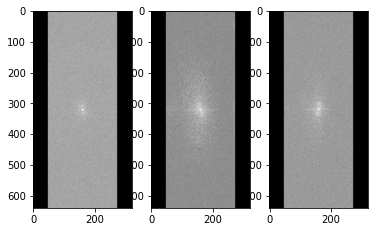

In [9]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10], cmap='gray')  # This shows coils 0, 5 and 10
# Note: np.abs() on complex data is the same as calculating the magnitude. 1e-9 is added to avoid log(0).


The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [10]:
import fastmri
from fastmri.data import transforms as T


In [11]:
slice_kspace_T = T.to_tensor(slice_kspace)               # Convert from numpy array to pytorch tensor
slice_image_T = fastmri.ifft2c(slice_kspace_T)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image_T)     # Compute absolute value to get a real image


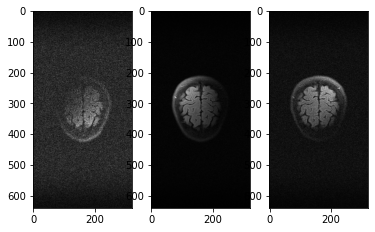

In [12]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [13]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
help(fastmri.rss)


Help on function rss in module fastmri.coil_combine:

rss(data:torch.Tensor, dim:int=0) -> torch.Tensor
    Compute the Root Sum of Squares (RSS).
    
    RSS is computed assuming that dim is the coil dimension.
    
    Args:
        data: The input tensor
        dim: The dimensions along which to apply the RSS transform
    
    Returns:
        The RSS value.



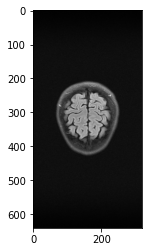

In [14]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')


In [15]:
slice_image_rss.max()


tensor(0.0003)

In [16]:
slice_image_rss.min()


tensor(3.8496e-06)

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [17]:
from fastmri.data.subsample import RandomMaskFunc, EquispacedMaskFunc

# GRAPPA type mask
mask_func = EquispacedMaskFunc(center_fractions=[0.08], accelerations=[4])  # Create the mask function object


In [18]:
masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)   # Apply the mask to k-space

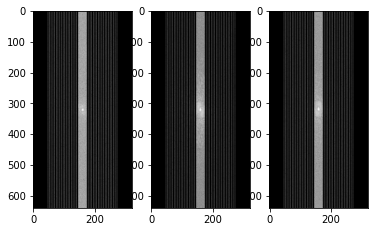

In [19]:
show_coils(np.log(np.abs(fastmri.complex_abs(masked_kspace_T).numpy()) + 1e-9), [0, 5, 10], cmap='gray')


Let's see what the subsampled image looks like:

In [20]:
sampled_image_T = fastmri.ifft2c(masked_kspace_T)                # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image_T)         # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)


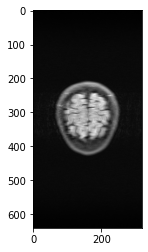

In [21]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

Let's see for R = 8

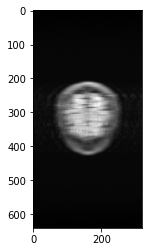

In [22]:
mask_func = EquispacedMaskFunc(center_fractions=[0.04], accelerations=[8])
masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
sampled_image_T = fastmri.ifft2c(masked_kspace_T)                # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image_T)         # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')


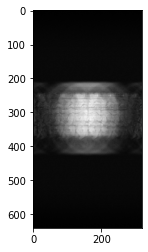

In [23]:
mask_func = EquispacedMaskFunc(center_fractions=[0.01], accelerations=[8])
masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)
sampled_image_T = fastmri.ifft2c(masked_kspace_T)                # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image_T)         # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')


Compare custom numpy rss calculation to the fastmri rss calculation above

In [12]:
from numpy import fft 

nCh, nFE, nPE = slice_kspace.shape
ref_img = np.zeros((nCh,nFE,nPE),dtype=np.float32)

for channel in range(nCh):
    ref_img[channel,:,:] = abs(fft.fftshift(fft.ifft2(slice_kspace[channel,:,:])))


In [15]:
Y_rss = np.sqrt(np.sum(np.square(ref_img),axis=0))


In [16]:
Y_rss.max()


5.594781e-07

In [17]:
Y_rss.min()


8.50657e-09

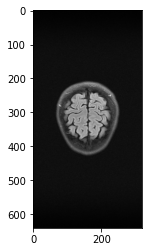

In [18]:
plt.imshow(np.abs(Y_rss), cmap='gray')


In [19]:
nCh, nFE, nPE = slice_kspace.shape
ref_img = np.zeros((nCh,nFE,nPE),dtype=np.float32)

for channel in range(nCh):
    ref_img[channel,:,:] = abs(fft.fftshift(fft.ifft2(slice_kspace[channel,:,:], norm='ortho')))


In [20]:
Y_rss = np.sqrt(np.sum(np.square(ref_img),axis=0))


In [21]:
Y_rss.max()


0.0002531909

In [22]:
Y_rss.min()


3.8496337e-06

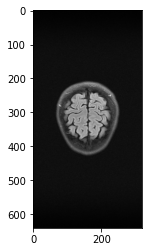

In [23]:
plt.imshow(np.abs(Y_rss), cmap='gray')
